In [1]:
from matplotlib import pyplot as plt
import numpy as np
import re
import scipy as sp
from scipy import stats
import seaborn as sns

%matplotlib inline

In [2]:
sequences = []
cur_seq = None

with open("../data/fasta/uniprot-von+willebrand+factor.fasta", "r") as f:
    for line in f:
        if line[0] == ">":
            if cur_seq is not None:
                sequences.append(cur_seq)
            cur_seq = {"name": line, "lines": []}
        else:
            cur_seq["lines"].append(line)

In [3]:
sequences = [seq for seq in sequences if len(seq["lines"]) > 2500 // 60]
sequences = [seq for seq in sequences if re.match(r">([a-z]+)\|([A-Z0-9]+)\|([A-Z0-9_]+) von Willebrand factor OS", seq["name"])]

In [4]:
with open("../data/fasta/vWF.fa", "w") as f:
    for seq in sequences:
        f.write(seq["name"])
        for line in seq["lines"]:
            f.write(line)

In [5]:
!cat ../data/alignment_3.clustal_num | wc -l

    7017


In [6]:
datas = []

for i in np.arange(4, 7017, 110):
    data = !cat ../data/alignment_4.clustal_num | tail -n +$i | head -n 108
    datas.append(data)

In [7]:
seq_dict = dict()

for r_i, data in enumerate(datas):
    for d in data:
        if r_i == 0:
            seq_dict[d.split(" ")[0].split("|")[2]] = d.split(" ")[-1].split("\t")[0]
            
        else:
            seq_dict[d.split(" ")[0].split("|")[2]] += d.split(" ")[-1].split("\t")[0]

In [8]:
aas = "A C D E F G H I K L M N P Q R S T V W Y -".split(" ")

In [9]:
def freq(l):
    freq_arr = np.zeros((len(aas), ), dtype=np.uint32)
    for a in l:
        if a in aas:
            freq_arr[aas.index(a)] += 1
    return freq_arr

result = np.zeros((len(list(seq_dict.values())[0]), len(aas)))
for i, tpl in enumerate(zip(*seq_dict.values())):
    result[i] = freq(tpl)

In [10]:
result.shape

(3297, 21)

In [11]:
entropy = np.zeros((result.shape[0], ))

for pos in range(result.shape[0]):
    entropy[pos] = stats.entropy(result[pos, :] / result[pos, :].sum())
    
l = np.where(np.array(list(seq_dict["VWF_HUMAN"])) != "-")[0]
START, FINISH = l[0], l[-1]
positions = [i for i in np.where(entropy < .5)[0] if i > START and i < FINISH]

In [16]:
indices = np.cumsum(np.array([(0 if c == "-" else 1) for c in seq_dict["VWF_HUMAN"]]))
out_of_margin = np.where(entropy < np.percentile(entropy, 2.5))
real_indices = indices[out_of_margin]

In [17]:
real_indices

array([ 112,  114,  125,  135,  141,  158,  159,  160,  161,  162,  163,
        166,  171,  185,  187,  189,  190,  191,  200,  202,  210,  225,
        250,  255,  263,  265,  269,  273,  275,  279,  285,  291,  295,
        296,  301,  304,  308,  312,  321,  325,  327,  328,  329,  331,
        334,  337,  338,  342,  348,  350,  352,  388,  392,  393,  395,
        397,  399,  400,  404,  405,  406,  408,  410,  412,  417,  423,
        431,  502,  504,  506,  523,  529,  534,  540,  550,  574,  613,
        661,  662,  665,  668,  669,  673,  679,  683,  685,  686,  687,
        689,  690,  692,  701,  707,  709,  713,  718,  725,  776,  787,
        811,  827, 1060, 1068, 1089, 1091, 1120, 1130, 1149, 1157, 1180,
       1183, 1184, 1185, 1190, 1196, 1199, 1209, 1222, 1227, 1234, 1237,
       1272, 1277, 1278, 1280, 1283, 1284, 1285, 1293, 1297, 1299, 1315,
       1349, 1351, 1504, 1510, 1514, 1573, 1578, 1579, 1581, 1614, 1627,
       1639, 1657, 1686, 1696, 1711, 1713, 1718, 17

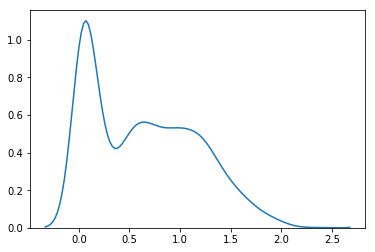

In [228]:
sns.kdeplot(entropy)